In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skopt import gp_minimize
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from bayes_opt import BayesianOptimization
import random
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading

In [ ]:
train_file_path = "D:\\dEEP LEARNING\\Assignment 3\\Google_Stock_Price_Train.csv"
test_file_path = "D:\\dEEP LEARNING\\Assignment 3\\Google_Stock_Price_Test.csv"
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
train_data_head = train_data.head()
test_data_head = test_data.head()
train_data_head, test_data_head

(       Date    Open    High     Low   Close      Volume
 0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
 1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
 2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
 3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
 4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800,
        Date    Open    High     Low   Close     Volume
 0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
 1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
 2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
 3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
 4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400)

In [ ]:
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%m/%d/%Y')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m/%d/%Y')
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_features = train_data[features]
test_features = test_data[features]
train_set, validation_set = train_test_split(train_features, test_size=0.2, shuffle=False)
train_set_summary = train_set.describe()
validation_set_summary = validation_set.describe()
test_features_summary = test_features.describe()
train_set_summary, validation_set_summary, test_features_summary

(              Open         High          Low        Volume
 count  1006.000000  1006.000000  1006.000000  1.006000e+03
 mean    481.099791   484.889722   476.756113  3.490249e+06
 std     121.355004   122.329345   119.965669  2.386458e+06
 min     279.120000   281.210000   277.220000  7.900000e+03
 25%     370.937500   376.482500   368.780000  1.817475e+06
 50%     517.930000   523.075000   513.620000  3.164300e+06
 75%     563.692500   568.875000   558.235000  4.409325e+06
 max     776.600000   779.980000   766.900000  2.497790e+07,
              Open        High         Low        Volume
 count  252.000000  252.000000  252.000000  2.520000e+02
 mean   743.732460  749.421667  737.597897  1.832176e+06
 std     34.832181   33.839595   35.511645  9.379025e+05
 min    667.850000  672.300000  663.060000  5.874000e+05
 25%    716.072500  719.862500  706.365000  1.264600e+06
 50%    743.010000  747.090000  736.780000  1.587300e+06
 75%    773.897500  778.915000  768.967500  2.077850e+06
 ma

### PREPROCESSING

In [ ]:
def create_lstm_data(data, target_column, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i+N].values)
        y.append(data[i+N:i+N+M][target_column].values)
    return np.array(X), np.array(y)

numerical_data = train_data[['Open', 'High', 'Low', 'Close', 'Volume']].replace(',', '', regex=True).astype(float)
test_numerical_data = test_data[['Open', 'High', 'Low', 'Close', 'Volume']].replace(',', '', regex=True).astype(float)
# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(numerical_data)
normalized_df = pd.DataFrame(normalized_data, columns=numerical_data.columns)
normalized_test_data = scaler.transform(test_numerical_data)
normalized_test_df = pd.DataFrame(normalized_test_data, columns=test_numerical_data.columns)

# sliding window parameters
N = 10
M = 1

X, y = create_lstm_data(normalized_df, target_column='Close', N=N, M=M)
X_test, y_test = create_lstm_data(normalized_test_df, target_column='Close', N=N, M=M)
# converting to tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Spliting into train and validation sets
train_size = int(0.8 * len(X_tensor))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

### VISUALISATION

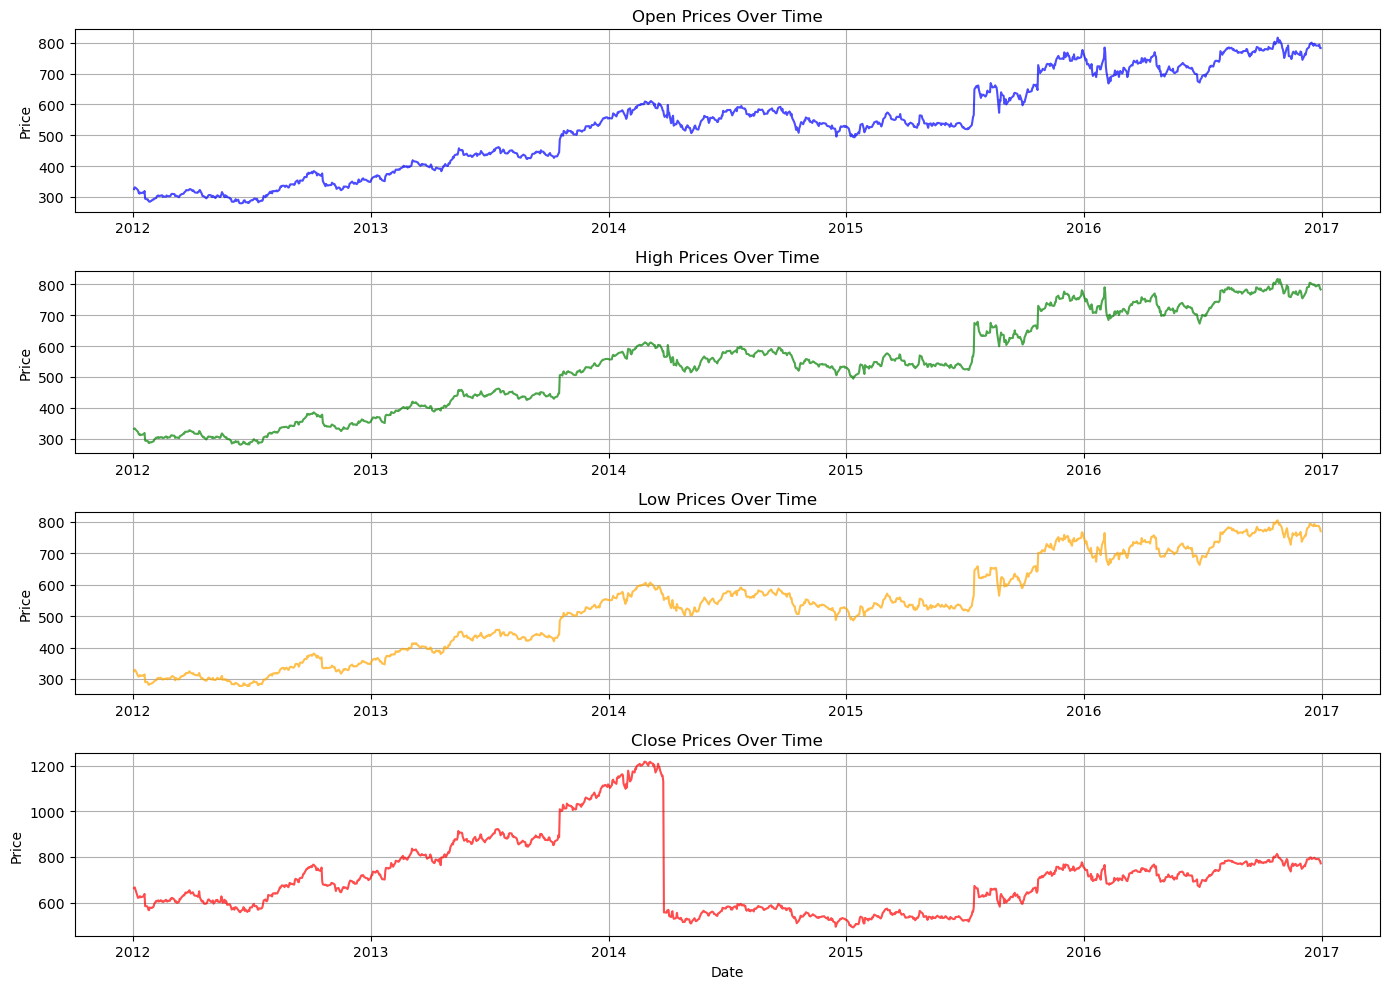

In [ ]:
plt.figure(figsize=(14, 10))
# Subplot for Open prices
plt.subplot(4, 1, 1)
plt.plot(train_data['Date'], train_data['Open'], label='Open', color='blue', alpha=0.7)
plt.title('Open Prices Over Time')
plt.ylabel('Price')
plt.grid()

# Subplot for High prices
plt.subplot(4, 1, 2)
plt.plot(train_data['Date'], train_data['High'], label='High', color='green', alpha=0.7)
plt.title('High Prices Over Time')
plt.ylabel('Price')
plt.grid()

# Subplot for Low prices
plt.subplot(4, 1, 3)
plt.plot(train_data['Date'], train_data['Low'], label='Low', color='orange', alpha=0.7)
plt.title('Low Prices Over Time')
plt.ylabel('Price')
plt.grid()

# Subplot for Close prices
plt.subplot(4, 1, 4)
# Check if 'Close' is already numeric; if not, remove commas and convert to numeric
if train_data['Close'].dtype == 'object':
    train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)
plt.plot(train_data['Date'], train_data['Close'], label='Close', color='red', alpha=0.7)
plt.title('Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.tight_layout()
plt.show()

# LSTM

In [ ]:
# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

Epoch 1/100, Train Loss: 0.0820, Val Loss: 0.0021
Epoch 2/100, Train Loss: 0.0187, Val Loss: 0.0133
Epoch 3/100, Train Loss: 0.0051, Val Loss: 0.0084
Epoch 4/100, Train Loss: 0.0041, Val Loss: 0.0007
Epoch 5/100, Train Loss: 0.0039, Val Loss: 0.0007
Epoch 6/100, Train Loss: 0.0035, Val Loss: 0.0028
Epoch 7/100, Train Loss: 0.0043, Val Loss: 0.0011
Epoch 8/100, Train Loss: 0.0038, Val Loss: 0.0007
Epoch 9/100, Train Loss: 0.0036, Val Loss: 0.0010
Epoch 10/100, Train Loss: 0.0031, Val Loss: 0.0006
Epoch 11/100, Train Loss: 0.0031, Val Loss: 0.0034
Epoch 12/100, Train Loss: 0.0030, Val Loss: 0.0005
Epoch 13/100, Train Loss: 0.0027, Val Loss: 0.0004
Epoch 14/100, Train Loss: 0.0026, Val Loss: 0.0004
Epoch 15/100, Train Loss: 0.0026, Val Loss: 0.0004
Epoch 16/100, Train Loss: 0.0022, Val Loss: 0.0005
Epoch 17/100, Train Loss: 0.0021, Val Loss: 0.0004
Epoch 18/100, Train Loss: 0.0024, Val Loss: 0.0009
Epoch 19/100, Train Loss: 0.0019, Val Loss: 0.0005
Epoch 20/100, Train Loss: 0.0019, Val Lo

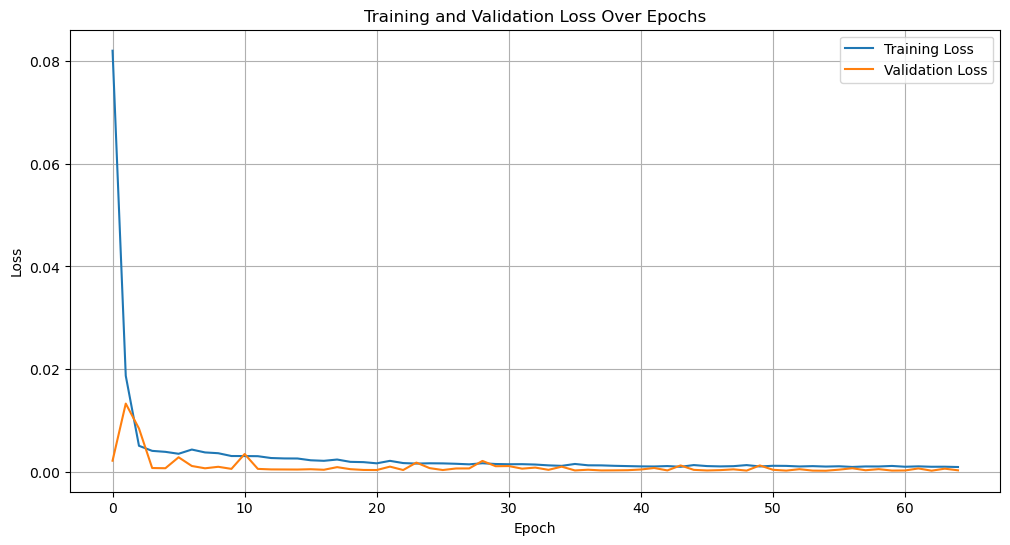

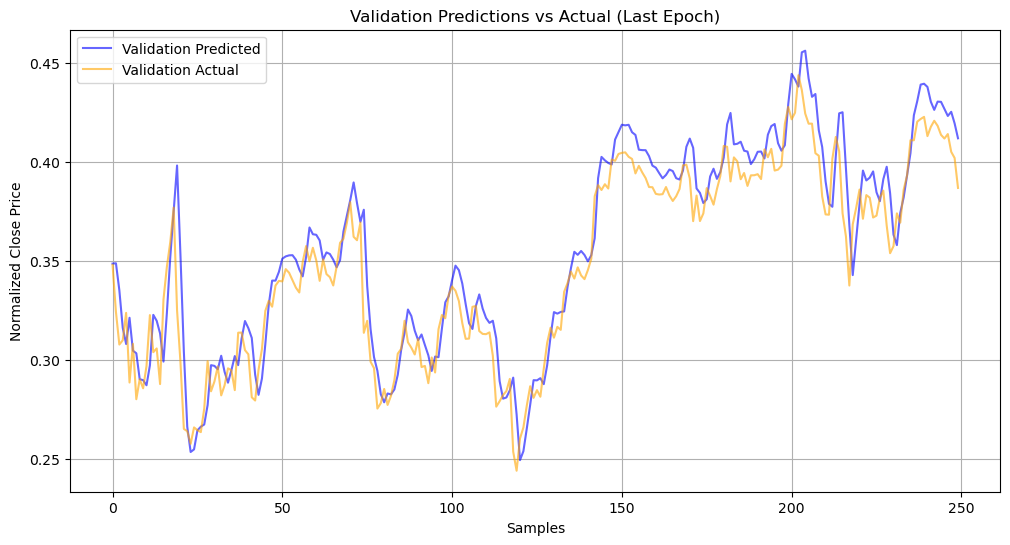

In [ ]:
set_seed(42)
input_dim = X.shape[2]
hidden_dim = 50
output_dim = M
num_layers = 2
learning_rate = 0.001
num_epochs = 100
patience = 10 

model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_actuals, val_actuals = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    epoch_val_pred, epoch_val_actual = [], [] 
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            epoch_val_pred.extend(y_pred.cpu().numpy())
            epoch_val_actual.extend(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_predictions.append(epoch_val_pred)  # Save predictions for the epoch
    val_actuals.append(epoch_val_actual)    # Save actual values for the epoch

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot predicted vs actual for the last epoch
val_pred_last = np.array(val_predictions[-1])
val_actual_last = np.array(val_actuals[-1])


plt.figure(figsize=(12, 6))
plt.plot(val_pred_last, label='Validation Predicted', color='blue', alpha=0.6)
plt.plot(val_actual_last, label='Validation Actual', color='orange', alpha=0.6)
plt.title('Validation Predictions vs Actual (Last Epoch)')
plt.xlabel('Samples')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid()
plt.show()

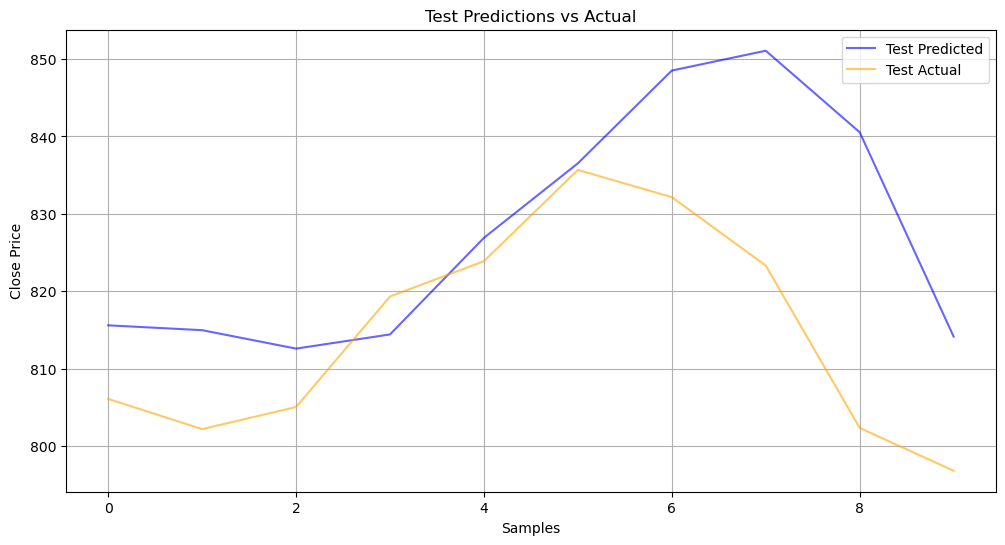

Test RMSE: 17.73
Test MAE: 13.83


In [ ]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy() 
    y_test_actual = y_test_tensor.cpu().numpy() 

y_test_pred = np.array(y_test_pred)
y_test_actual = np.array(y_test_actual)
close_min = scaler.data_min_[3]
close_max = scaler.data_max_[3]
y_test_pred_rescaled = y_test_pred.flatten() * (close_max - close_min) + close_min
y_test_actual_rescaled = y_test_actual.flatten() * (close_max - close_min) + close_min

# Plot predicted vs actual for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_pred_rescaled, label='Test Predicted', color='blue', alpha=0.6)
plt.plot(y_test_actual_rescaled, label='Test Actual', color='orange', alpha=0.6)
plt.title('Test Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Calculate regression metrics
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

In [ ]:
mape = np.mean(np.abs((y_test_actual_rescaled - y_test_pred_rescaled) / y_test_actual_rescaled)) * 100
print(f"Test MAPE: {mape:.2f}%")

Test MAPE: 1.71%


### Fine Tuning with bayesian optimisation

In [ ]:
set_seed(42)
# Objective function for Bayesian Optimization
def lstm_objective(hidden_dim, learning_rate, num_layers):
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    learning_rate = float(learning_rate)
    
    model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5  
    num_epochs = 100
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    return -best_val_loss

# Define the hyperparameter space
pbounds = {
    'hidden_dim': (10,50),       
    'learning_rate': (1e-3, 1e-2), 
    'num_layers': (1, 2),        
}

optimizer = BayesianOptimization(
    f=lstm_objective,  
    pbounds=pbounds,   
    random_state=42,  
    verbose=2       
)

optimizer.maximize(n_iter=50)
print("Best Hyperparameters:", optimizer.max)


|   iter    |  target   | hidden... | learni... | num_la... |
-------------------------------------------------------------
Early stopping triggered.
| 1         | -0.000467 | 24.98     | 0.009556  | 1.732     |
Early stopping triggered.
| 2         | -0.000271 | 33.95     | 0.002404  | 1.156     |
Early stopping triggered.
| 3         | -0.000178 | 12.32     | 0.008796  | 1.601     |
Early stopping triggered.
| 4         | -0.000312 | 38.32     | 0.001185  | 1.97      |
Early stopping triggered.
| 5         | -0.000197 | 43.3      | 0.002911  | 1.182     |
Early stopping triggered.
| 6         | -0.000368 | 12.4      | 0.002179  | 1.606     |
Early stopping triggered.
| 7         | -0.000506 | 16.43     | 0.004591  | 1.087     |
Early stopping triggered.
| 8         | -0.000246 | 23.01     | 0.005312  | 1.143     |
Early stopping triggered.
| 9         | -0.000215 | 47.72     | 0.004311  | 1.221     |
Early stopping triggered.
| 10        | -0.000158 | 45.76     | 0.008754  | 1.413   

#### Retraraining with best parameters

Epoch 1/100, Train Loss: 0.0195, Val Loss: 0.0055
Epoch 2/100, Train Loss: 0.0033, Val Loss: 0.0007
Epoch 3/100, Train Loss: 0.0029, Val Loss: 0.0067
Epoch 4/100, Train Loss: 0.0023, Val Loss: 0.0004
Epoch 5/100, Train Loss: 0.0020, Val Loss: 0.0008
Epoch 6/100, Train Loss: 0.0015, Val Loss: 0.0007
Epoch 7/100, Train Loss: 0.0021, Val Loss: 0.0005
Epoch 8/100, Train Loss: 0.0014, Val Loss: 0.0008
Epoch 9/100, Train Loss: 0.0011, Val Loss: 0.0003
Epoch 10/100, Train Loss: 0.0010, Val Loss: 0.0002
Epoch 11/100, Train Loss: 0.0012, Val Loss: 0.0002
Epoch 12/100, Train Loss: 0.0012, Val Loss: 0.0009
Epoch 13/100, Train Loss: 0.0013, Val Loss: 0.0004
Epoch 14/100, Train Loss: 0.0012, Val Loss: 0.0002
Epoch 15/100, Train Loss: 0.0011, Val Loss: 0.0006
Epoch 16/100, Train Loss: 0.0010, Val Loss: 0.0002
Epoch 17/100, Train Loss: 0.0010, Val Loss: 0.0002
Epoch 18/100, Train Loss: 0.0011, Val Loss: 0.0005
Epoch 19/100, Train Loss: 0.0009, Val Loss: 0.0002
Epoch 20/100, Train Loss: 0.0010, Val Lo

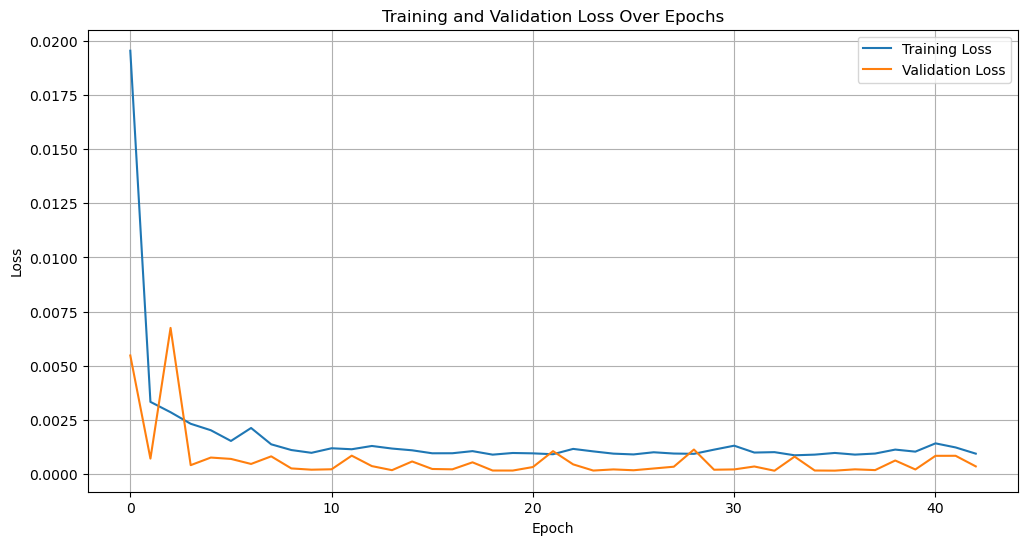

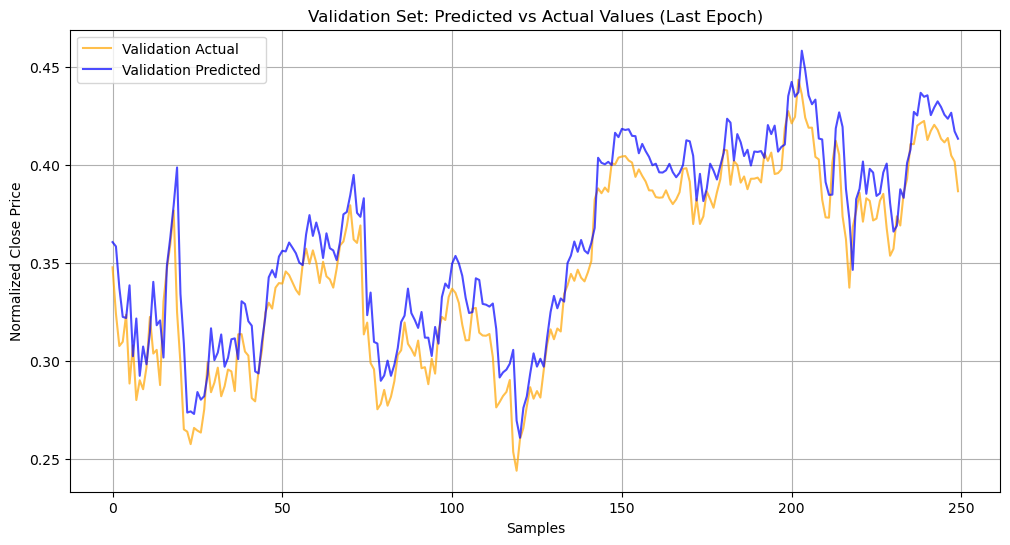

In [ ]:
best_params = optimizer.max['params']
hidden_dim = int(best_params['hidden_dim'])
learning_rate = float(best_params['learning_rate'])
num_layers = int(best_params['num_layers'])
model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience_counter = 0
patience = 10  
num_epochs = 100  
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_actuals, val_actuals = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    epoch_val_pred, epoch_val_actual = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            epoch_val_pred.extend(y_pred.cpu().numpy())
            epoch_val_actual.extend(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_predictions.append(epoch_val_pred)
    val_actuals.append(epoch_val_actual)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot predicted vs actual for the last epoch
val_pred_last = np.array(val_predictions[-1])
val_actual_last = np.array(val_actuals[-1])

plt.figure(figsize=(12, 6))
plt.plot(val_actual_last, label='Validation Actual', color='orange', alpha=0.7)
plt.plot(val_pred_last, label='Validation Predicted', color='blue', alpha=0.7)
plt.title('Validation Set: Predicted vs Actual Values (Last Epoch)')
plt.xlabel('Samples')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid()
plt.show()

#### testing with test set

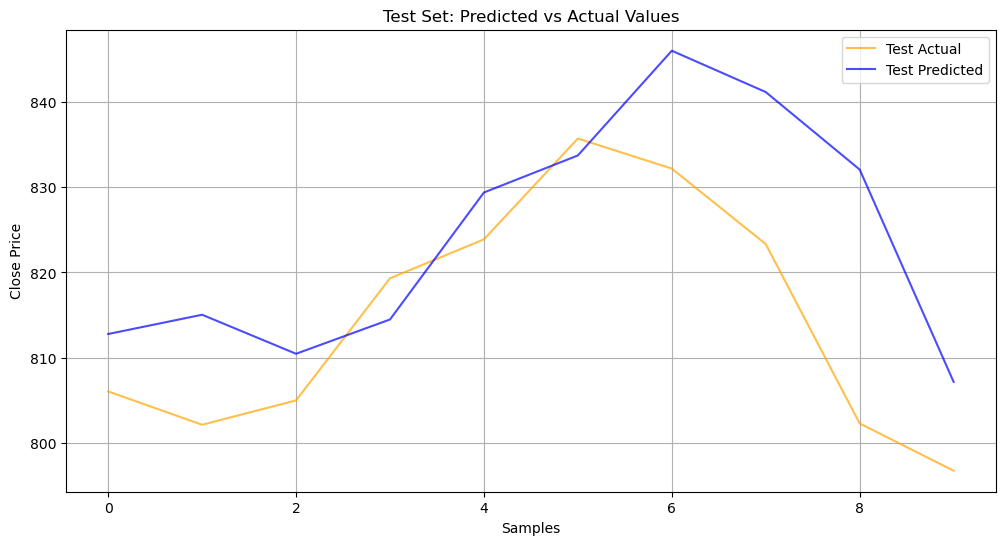

Test RMSE: 13.40
Test MAE: 10.90
Test MAPE: 1.34%


In [ ]:
model.eval()
test_predictions, test_actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        test_predictions.extend(y_pred.cpu().numpy())
        test_actuals.extend(y_batch.cpu().numpy())
test_predictions = np.array(test_predictions).flatten()
test_actuals = np.array(test_actuals).flatten()

close_min = scaler.data_min_[numerical_data.columns.get_loc('Close')]
close_max = scaler.data_max_[numerical_data.columns.get_loc('Close')]

test_predictions_rescaled = test_predictions * (close_max - close_min) + close_min
test_actuals_rescaled = test_actuals * (close_max - close_min) + close_min

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_rescaled, label='Test Actual', color='orange', alpha=0.7)
plt.plot(test_predictions_rescaled, label='Test Predicted', color='blue', alpha=0.7)
plt.title('Test Set: Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

test_rmse = np.sqrt(mean_squared_error(test_actuals_rescaled, test_predictions_rescaled))
test_mae = mean_absolute_error(test_actuals_rescaled, test_predictions_rescaled)
test_mape = np.mean(np.abs((test_actuals_rescaled - test_predictions_rescaled) / test_actuals_rescaled)) * 100

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")


#### Feature engineering and fEATURE SELECTION








In [ ]:
# Feature Engineering Function
set_seed(42)
def add_features(df):
    df['MA5'] = df['Close'].rolling(window=5).mean().bfill()
    df['MA10'] = df['Close'].rolling(window=10).mean().bfill()
    df['Change'] = df['Close'].pct_change().fillna(0)  # Percentage change
    df['Volatility'] = df['Close'].rolling(window=5).std().bfill()  # Rolling std dev
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low']  # High-Low percentage
    return df

# Apply Feature Engineering to Train and Test Data
train_data = add_features(train_data)
test_data = add_features(test_data)

# Select Features for Normalization
numerical_data1 = train_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'Change', 'Volatility', 'High_Low_Pct']]
test_features1 = test_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'Change', 'Volatility', 'High_Low_Pct']]

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(numerical_data1)
normalized_df_feature = pd.DataFrame(normalized_data, columns=numerical_data1.columns)
normalized_test_data = scaler.transform(test_features1)
normalized_test_df_feature = pd.DataFrame(normalized_test_data, columns=test_features1.columns)

# Define sliding window parameters
N = 10  
M = 1   

X, y = create_lstm_data(normalized_df_feature, target_column='Close', N=N, M=M)
X_test, y_test = create_lstm_data(normalized_test_df_feature, target_column='Close', N=N, M=M)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_size = int(0.8 * len(X_tensor))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

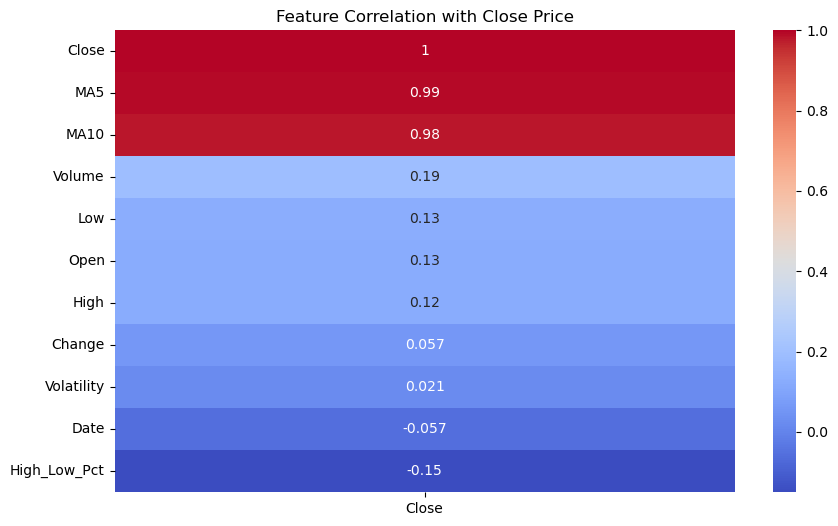

In [ ]:
#  correlation matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['Close']].sort_values(by='Close', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Close Price")
plt.show()

#### Random forest regressor to find the most correlated feature with "Close"

In [ ]:
rf = RandomForestRegressor(random_state=42)

selector = RFE(estimator=rf, n_features_to_select=2)
X_selected = selector.fit_transform(numerical_data1, train_data['Close'])

selected_features = numerical_data1.columns[selector.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['MA5', 'MA10']


### Training model with only selected feature

Epoch 1/100, Train Loss: 0.0847, Val Loss: 0.0042
Epoch 2/100, Train Loss: 0.0103, Val Loss: 0.0026
Epoch 3/100, Train Loss: 0.0056, Val Loss: 0.0008
Epoch 4/100, Train Loss: 0.0053, Val Loss: 0.0016
Epoch 5/100, Train Loss: 0.0049, Val Loss: 0.0008
Epoch 6/100, Train Loss: 0.0045, Val Loss: 0.0007
Epoch 7/100, Train Loss: 0.0044, Val Loss: 0.0012
Epoch 8/100, Train Loss: 0.0041, Val Loss: 0.0015
Epoch 9/100, Train Loss: 0.0039, Val Loss: 0.0009
Epoch 10/100, Train Loss: 0.0040, Val Loss: 0.0006
Epoch 11/100, Train Loss: 0.0033, Val Loss: 0.0006
Epoch 12/100, Train Loss: 0.0030, Val Loss: 0.0007
Epoch 13/100, Train Loss: 0.0028, Val Loss: 0.0007
Epoch 14/100, Train Loss: 0.0030, Val Loss: 0.0009
Epoch 15/100, Train Loss: 0.0028, Val Loss: 0.0005
Epoch 16/100, Train Loss: 0.0025, Val Loss: 0.0004
Epoch 17/100, Train Loss: 0.0024, Val Loss: 0.0006
Epoch 18/100, Train Loss: 0.0022, Val Loss: 0.0004
Epoch 19/100, Train Loss: 0.0019, Val Loss: 0.0004
Epoch 20/100, Train Loss: 0.0019, Val Lo

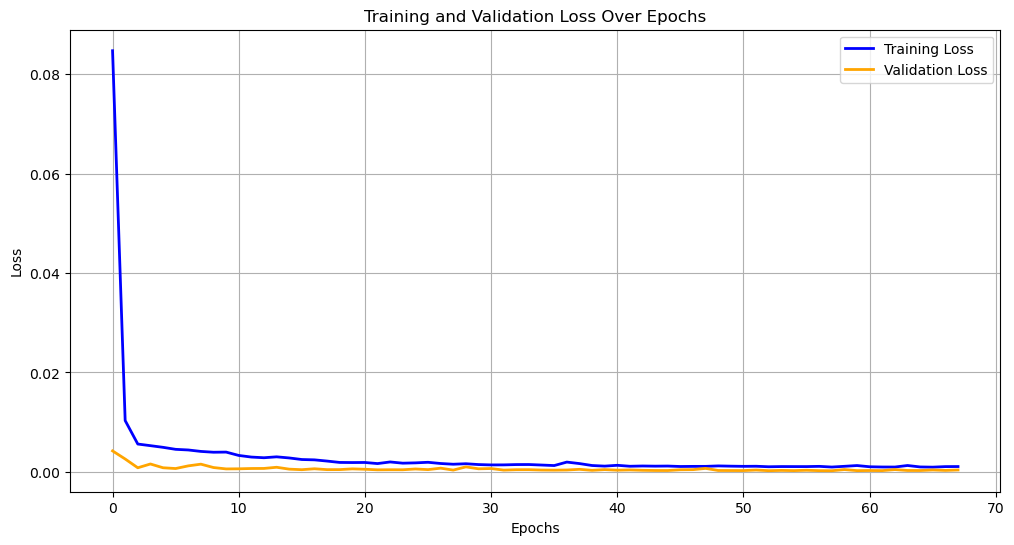

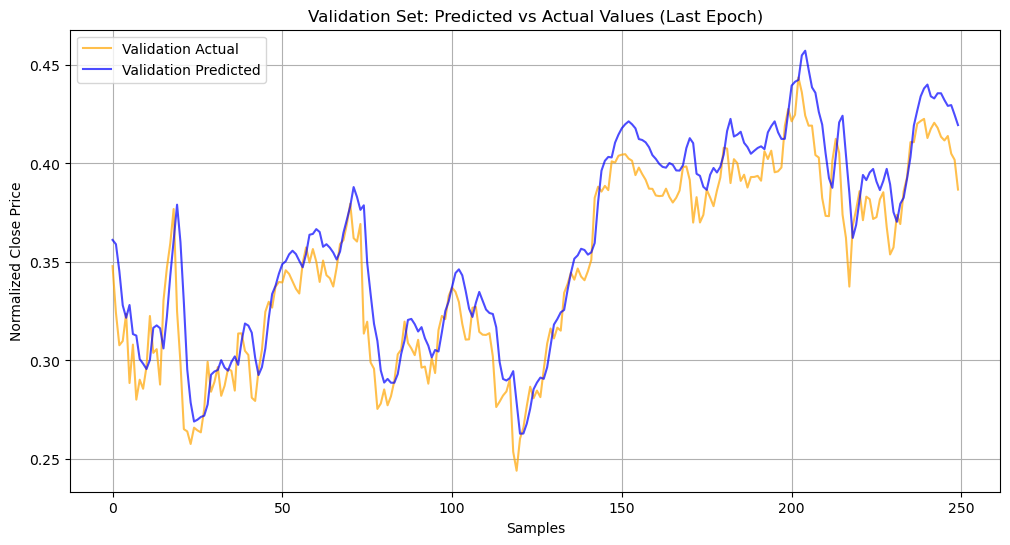

In [ ]:
# Prepare data with refined feature selection
set_seed(42)
numerical_data = train_data[[ 'Close','MA5', 'MA10']] 
test_features = test_data[['Close','MA5', 'MA10']] 

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(numerical_data)
normalized_df_feature = pd.DataFrame(normalized_data, columns=numerical_data.columns)
normalized_test_data = scaler.transform(test_features)
normalized_test_df_feature = pd.DataFrame(normalized_test_data, columns=test_features.columns)

X, y = create_lstm_data(normalized_df_feature, target_column='Close', N=N, M=M)
X_test, y_test = create_lstm_data(normalized_test_df_feature, target_column='Close', N=N, M=M)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_size = int(0.8 * len(X_tensor))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]
input_dim = X.shape[2]  
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
val_predictions, val_actuals = [], [] 
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    epoch_val_pred, epoch_val_actual = [], []  
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            epoch_val_pred.extend(y_pred.cpu().numpy())
            epoch_val_actual.extend(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_predictions.append(epoch_val_pred) 
    val_actuals.append(epoch_val_actual)   

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
 
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2, color='blue')
plt.plot(val_losses, label='Validation Loss', linewidth=2, color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
val_pred_last = np.array(val_predictions[-1])
val_actual_last = np.array(val_actuals[-1])
plt.figure(figsize=(12, 6))
plt.plot(val_actual_last, label='Validation Actual', color='orange', alpha=0.7)
plt.plot(val_pred_last, label='Validation Predicted', color='blue', alpha=0.7)
plt.title('Validation Set: Predicted vs Actual Values (Last Epoch)')
plt.xlabel('Samples')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid()
plt.show()

#### testing

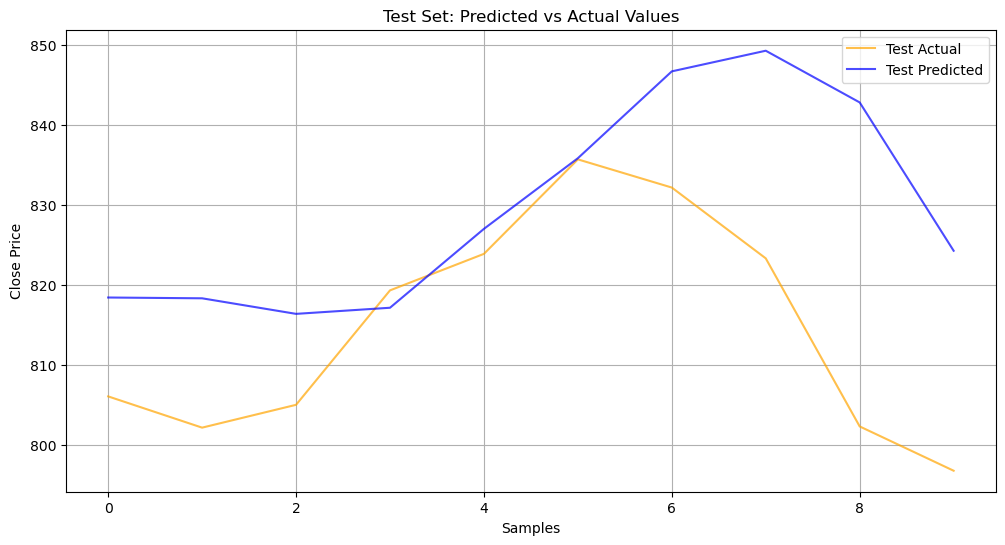

Test RMSE: 19.57
Test MAE: 15.37
Test MAPE: 1.90%


In [ ]:
# Evaluate on the test set
model.eval()
y_test_pred, y_test_actual = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_test_pred.extend(y_pred.cpu().numpy())
        y_test_actual.extend(y_batch.cpu().numpy())

close_min = scaler.data_min_[0] 
close_max = scaler.data_max_[0]
y_test_pred_rescaled = np.array(y_test_pred).flatten() * (close_max - close_min) + close_min
y_test_actual_rescaled = np.array(y_test_actual).flatten() * (close_max - close_min) + close_min

# Plots
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_rescaled, label='Test Actual', color='orange', alpha=0.7)
plt.plot(y_test_pred_rescaled, label='Test Predicted', color='blue', alpha=0.7)
plt.title('Test Set: Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Calculate performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
test_mape = np.mean(np.abs((y_test_actual_rescaled - y_test_pred_rescaled) / y_test_actual_rescaled)) * 100

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

### fINE TUNING with bayesian optimisation

In [ ]:
set_seed(42)
def lstm_objective(hidden_dim, learning_rate, num_layers, look_back_window):
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    learning_rate = float(learning_rate)
    look_back_window = int(look_back_window) 

    selected_features = ['Close'] 
    X, y = create_lstm_data(normalized_df_feature[selected_features], target_column='Close', N=look_back_window, M=M)

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

    train_size = int(0.8 * len(X_tensor))
    X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

    batch_size = 32
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    input_dim = X.shape[2]
    output_dim = M
    model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 100
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return -best_val_loss


# Define the hyperparameter space
pbounds = {
    'hidden_dim': (50, 100),      
    'learning_rate': (1e-4, 1e-2),  
    'num_layers': (2, 4),          
    'look_back_window': (10, 19) 
}

optimizer = BayesianOptimization(
    f=lstm_objective, 
    pbounds=pbounds,   
    random_state=42,   
    verbose=2         
)

optimizer.maximize(init_points=20, n_iter=100)
print("Best Hyperparameters:", optimizer.max)

|   iter    |  target   | hidden... | learni... | look_b... | num_la... |
-------------------------------------------------------------------------
Early stopping triggered.
| 1         | -0.000160 | 68.73     | 0.009512  | 16.59     | 3.197     |
Early stopping triggered.
| 2         | -0.000515 | 57.8      | 0.001644  | 10.52     | 3.732     |
Early stopping triggered.
| 3         | -0.000192 | 80.06     | 0.00711   | 10.19     | 3.94      |
Early stopping triggered.
| 4         | -0.000206 | 91.62     | 0.002202  | 11.64     | 2.367     |
Early stopping triggered.
| 5         | -0.000168 | 65.21     | 0.005295  | 13.89     | 2.582     |
Early stopping triggered.
| 6         | -0.000214 | 80.59     | 0.001481  | 12.63     | 2.733     |
Early stopping triggered.
| 7         | -0.000174 | 72.8      | 0.007873  | 11.8      | 3.028     |
Early stopping triggered.
| 8         | -0.000418 | 79.62     | 0.0005599 | 15.47     | 2.341     |
Early stopping triggered.
| 9         | -0.000190 | 

#### Retraining with best hyperparameters and testing

Training with Best Parameters: Hidden Dim: 96, Learning Rate: 0.008958790769233723,  Num Layers: 3, Look Back Window: 15
Epoch 1/50, Train Loss: 0.0367, Val Loss: 0.0094
Validation loss improved to 0.0094, saving model.
Epoch 2/50, Train Loss: 0.0068, Val Loss: 0.0008
Validation loss improved to 0.0008, saving model.
Epoch 3/50, Train Loss: 0.0036, Val Loss: 0.0009
No improvement in validation loss for 1 epoch(s).
Epoch 4/50, Train Loss: 0.0035, Val Loss: 0.0004
Validation loss improved to 0.0004, saving model.
Epoch 5/50, Train Loss: 0.0024, Val Loss: 0.0003
Validation loss improved to 0.0003, saving model.
Epoch 6/50, Train Loss: 0.0022, Val Loss: 0.0007
No improvement in validation loss for 1 epoch(s).
Epoch 7/50, Train Loss: 0.0014, Val Loss: 0.0008
No improvement in validation loss for 2 epoch(s).
Epoch 8/50, Train Loss: 0.0017, Val Loss: 0.0003
No improvement in validation loss for 3 epoch(s).
Epoch 9/50, Train Loss: 0.0023, Val Loss: 0.0004
No improvement in validation loss for 

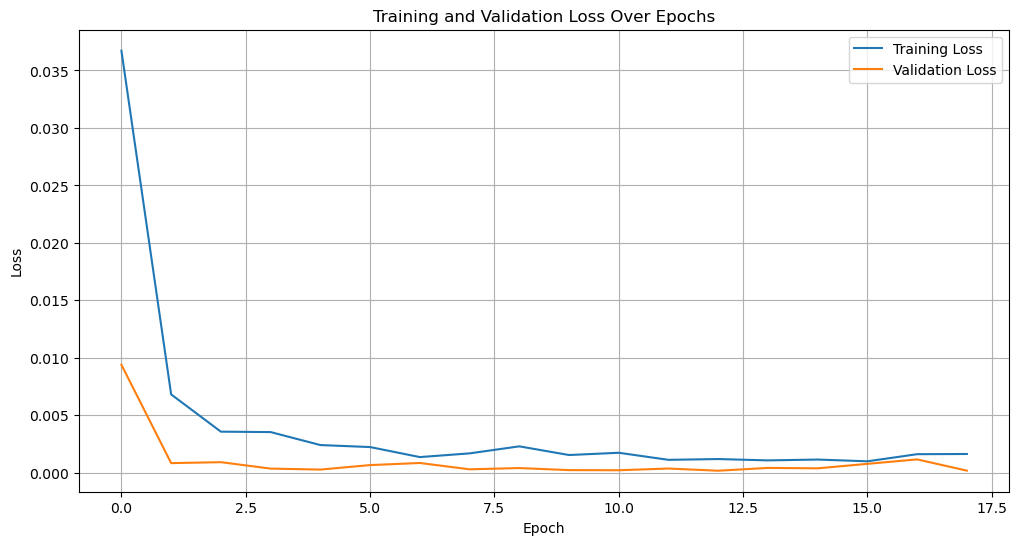

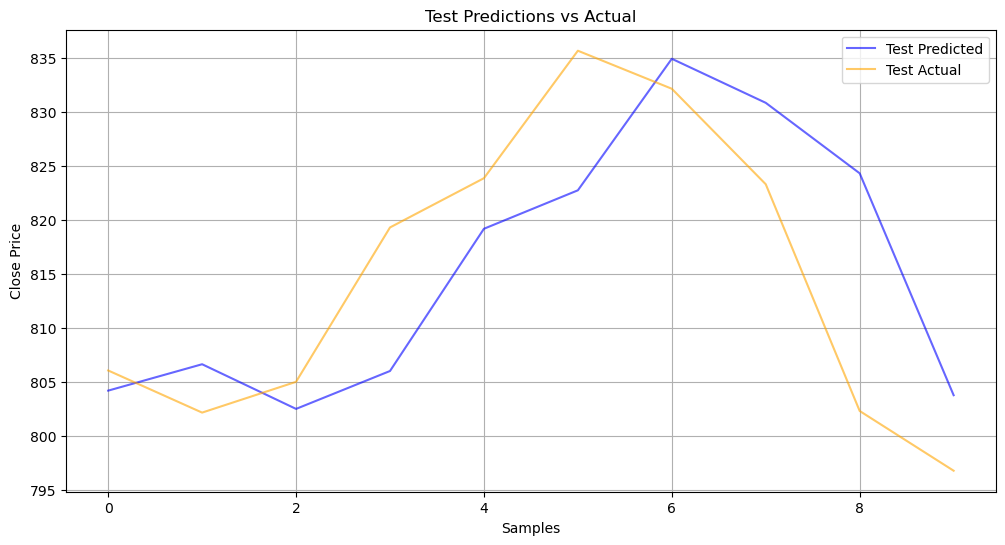

Test RMSE: 9.96
Test MAE: 7.90


In [ ]:
set_seed(42)
best_params=optimizer.max['params']
hidden_dim = int(best_params['hidden_dim'])
learning_rate = float(best_params['learning_rate'])
num_layers = int(best_params['num_layers'])
look_back_window = int(best_params['look_back_window']) 
print(f"Training with Best Parameters: Hidden Dim: {hidden_dim}, Learning Rate: {learning_rate},  Num Layers: {num_layers}, Look Back Window: {look_back_window}")

# Initialize the final model
input_dim = X.shape[2]
output_dim = M
model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50
train_losses, val_losses = [], []

patience = 5 
best_val_loss = float('inf')  
patience_counter = 0 

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Early stopping logic
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
        print(f"Validation loss improved to {best_val_loss:.4f}, saving model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Testing
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()
    y_test_actual = y_test_tensor.cpu().numpy()

close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
y_test_pred_rescaled = y_test_pred.flatten() * (close_max - close_min) + close_min
y_test_actual_rescaled = y_test_actual.flatten() * (close_max - close_min) + close_min

plt.figure(figsize=(12, 6))
plt.plot(y_test_pred_rescaled, label='Test Predicted', color='blue', alpha=0.6)
plt.plot(y_test_actual_rescaled, label='Test Actual', color='orange', alpha=0.6)
plt.title('Test Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

In [ ]:
mape = np.mean(np.abs((y_test_actual_rescaled - y_test_pred_rescaled) / y_test_actual_rescaled)) * 100
print(f"Test MAPE: {mape:.2f}%")

Test MAPE: 0.97%


# Vanilla RNN

In [ ]:
# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :]) 
        return out

Epoch 1/100, Train Loss: 0.0740, Val Loss: 0.0133
Epoch 2/100, Train Loss: 0.0194, Val Loss: 0.0008
Epoch 3/100, Train Loss: 0.0033, Val Loss: 0.0017
Epoch 4/100, Train Loss: 0.0023, Val Loss: 0.0004
Epoch 5/100, Train Loss: 0.0023, Val Loss: 0.0010
Epoch 6/100, Train Loss: 0.0021, Val Loss: 0.0005
Epoch 7/100, Train Loss: 0.0020, Val Loss: 0.0003
Epoch 8/100, Train Loss: 0.0018, Val Loss: 0.0006
Epoch 9/100, Train Loss: 0.0019, Val Loss: 0.0005
Epoch 10/100, Train Loss: 0.0019, Val Loss: 0.0005
Epoch 11/100, Train Loss: 0.0018, Val Loss: 0.0004
Epoch 12/100, Train Loss: 0.0015, Val Loss: 0.0004
Early stopping triggered.


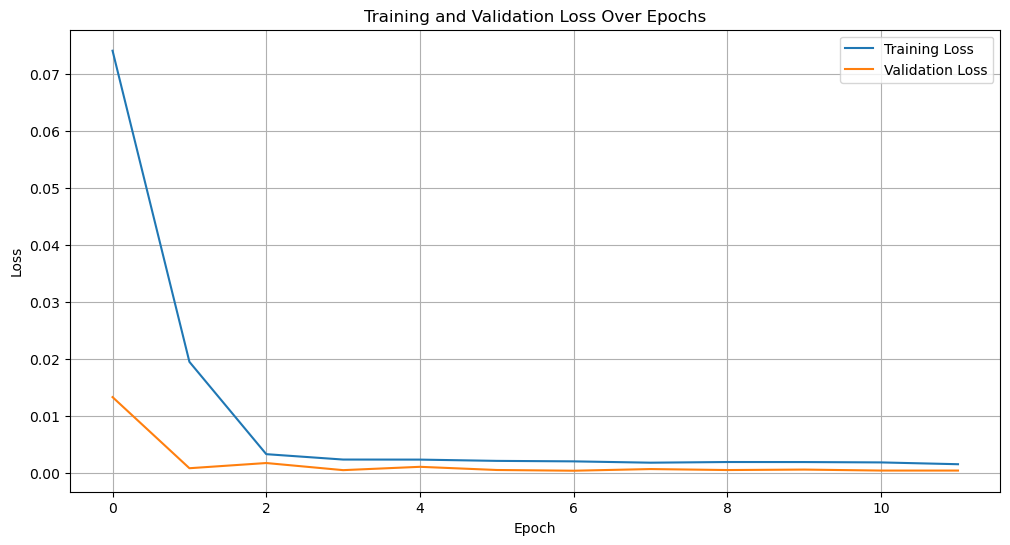

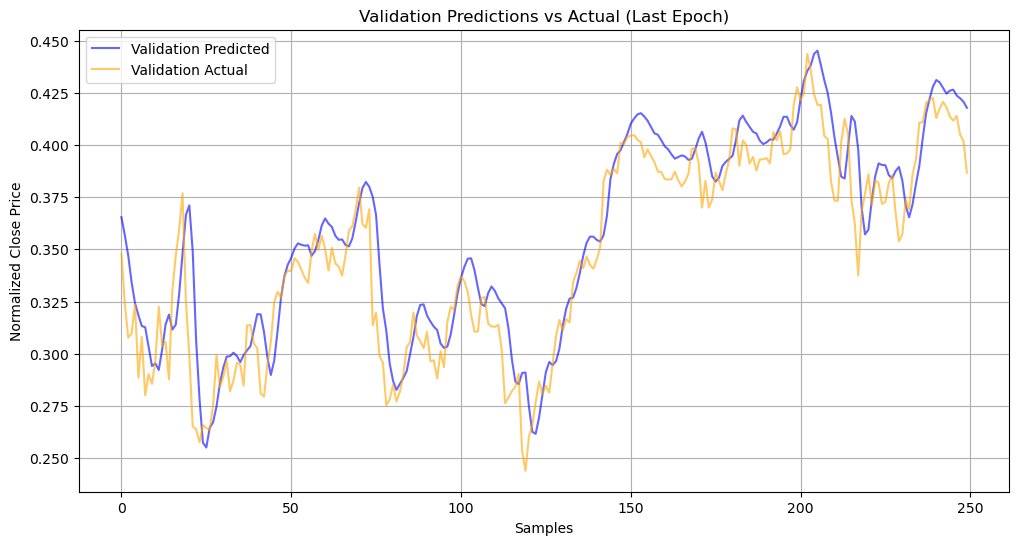

In [ ]:
set_seed(42)
# Model parameters
input_dim = X.shape[2]
hidden_dim = 50
output_dim = M
num_layers = 1
learning_rate = 0.001
num_epochs = 100
patience = 5  

model = VanillaRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

model.eval()
val_pred_last, val_actual_last = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        val_pred_last.extend(y_pred.cpu().numpy())
        val_actual_last.extend(y_batch.cpu().numpy())

val_pred_last = np.array(val_pred_last).flatten()
val_actual_last = np.array(val_actual_last).flatten()

plt.figure(figsize=(12, 6))
plt.plot(val_pred_last, label='Validation Predicted', color='blue', alpha=0.6)
plt.plot(val_actual_last, label='Validation Actual', color='orange', alpha=0.6)
plt.title('Validation Predictions vs Actual (Last Epoch)')
plt.xlabel('Samples')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid()
plt.show()

#### Testing

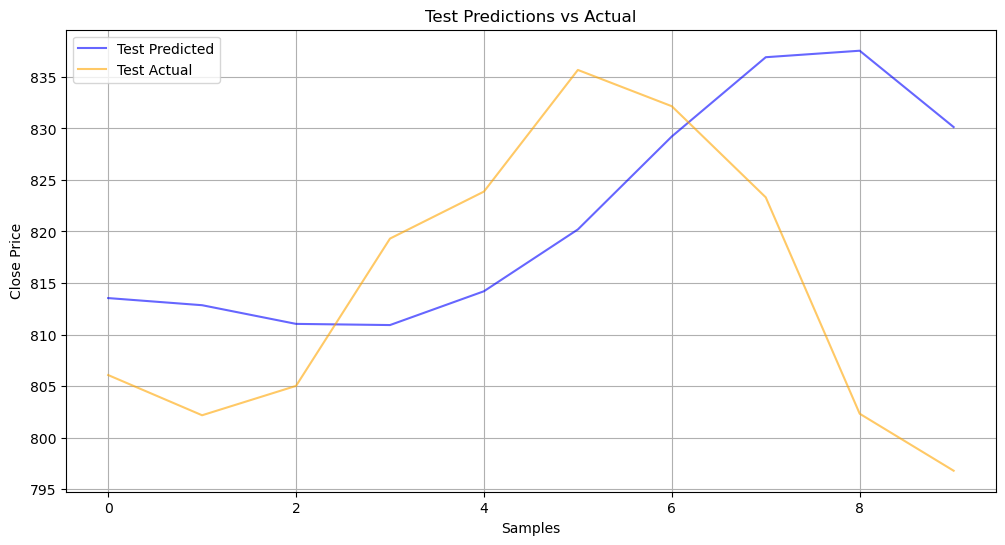

Test RMSE: 17.76
Test MAE: 14.28


In [ ]:
set_seed(42)
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()
    y_test_actual = y_test_tensor.cpu().numpy()

close_min = scaler.data_min_[3]
close_max = scaler.data_max_[3]

y_test_pred_rescaled = y_test_pred.flatten() * (close_max - close_min) + close_min
y_test_actual_rescaled = y_test_actual.flatten() * (close_max - close_min) + close_min

plt.figure(figsize=(12, 6))
plt.plot(y_test_pred_rescaled, label='Test Predicted', color='blue', alpha=0.6)
plt.plot(y_test_actual_rescaled, label='Test Actual', color='orange', alpha=0.6)
plt.title('Test Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

In [8]:
mape = np.mean(np.abs((y_test_actual_rescaled - y_test_pred_rescaled) / y_test_actual_rescaled)) * 100
print(f"Test MAPE: {mape:.2f}%")

Test MAPE: 1.76%


#### Tuning

In [ ]:
set_seed(42)
def lstm_objective(hidden_dim, learning_rate, num_layers):
   
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    learning_rate = float(learning_rate)
    
    model = VanillaRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5  
    num_epochs = 100 
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return -best_val_loss

# Define the hyperparameter space
pbounds = {
    'hidden_dim': (10,50),         
    'learning_rate': (1e-3, 1e-2),  
    'num_layers': (1, 2),        
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=lstm_objective,  
    pbounds=pbounds,  
    random_state=42, 
    verbose=2        
)

optimizer.maximize(n_iter=100)

# Display the best hyperparameters
print("Best Hyperparameters:", optimizer.max)

|   iter    |  target   | hidden... | learni... | num_la... |
-------------------------------------------------------------
Early stopping triggered.
| 1         | -0.000180 | 24.98     | 0.009556  | 1.732     |
Early stopping triggered.
| 2         | -0.000193 | 33.95     | 0.002404  | 1.156     |
Early stopping triggered.
| 3         | -0.000172 | 12.32     | 0.008796  | 1.601     |
Early stopping triggered.
| 4         | -0.000238 | 38.32     | 0.001185  | 1.97      |
Early stopping triggered.
| 5         | -0.000303 | 43.3      | 0.002911  | 1.182     |
Early stopping triggered.
| 6         | -0.000198 | 18.17     | 0.007246  | 1.003     |
Early stopping triggered.
| 7         | -0.000181 | 10.07     | 0.004324  | 1.068     |
Early stopping triggered.
| 8         | -0.000167 | 29.3      | 0.006547  | 1.975     |
Early stopping triggered.
| 9         | -0.000184 | 28.22     | 0.005698  | 1.0       |
Early stopping triggered.
| 10        | -0.000161 | 31.47     | 0.006285  | 1.994   

Epoch 1/100, Train Loss: 0.0284, Val Loss: 0.0039
Epoch 2/100, Train Loss: 0.0016, Val Loss: 0.0010
Epoch 3/100, Train Loss: 0.0019, Val Loss: 0.0002
Epoch 4/100, Train Loss: 0.0020, Val Loss: 0.0005
Epoch 5/100, Train Loss: 0.0013, Val Loss: 0.0002
Epoch 6/100, Train Loss: 0.0012, Val Loss: 0.0004
Epoch 7/100, Train Loss: 0.0011, Val Loss: 0.0002
Epoch 8/100, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/100, Train Loss: 0.0011, Val Loss: 0.0002
Epoch 10/100, Train Loss: 0.0010, Val Loss: 0.0006
Epoch 11/100, Train Loss: 0.0014, Val Loss: 0.0002
Epoch 12/100, Train Loss: 0.0015, Val Loss: 0.0006
Epoch 13/100, Train Loss: 0.0011, Val Loss: 0.0004
Epoch 14/100, Train Loss: 0.0011, Val Loss: 0.0002
Epoch 15/100, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 16/100, Train Loss: 0.0012, Val Loss: 0.0021
Epoch 17/100, Train Loss: 0.0012, Val Loss: 0.0004
Early stopping triggered.


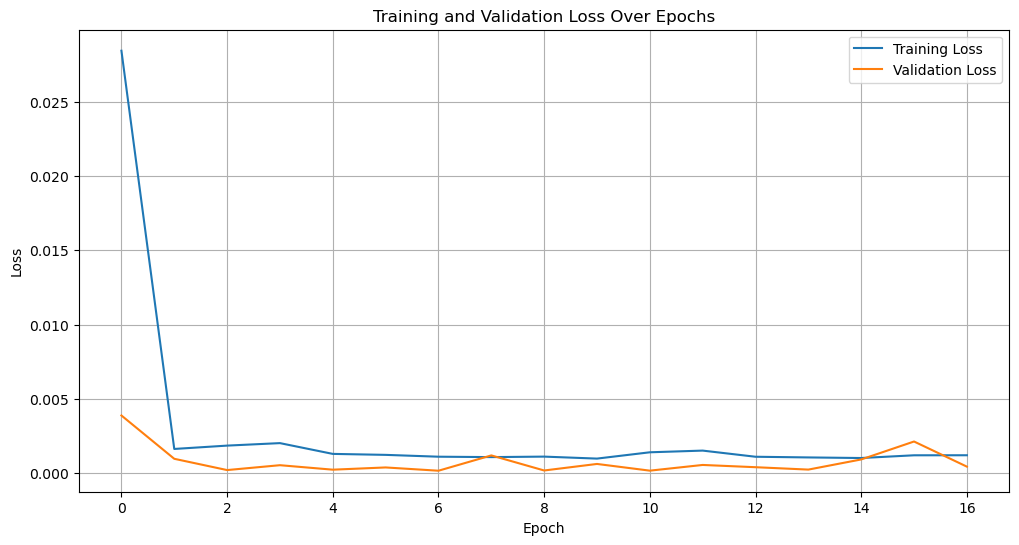

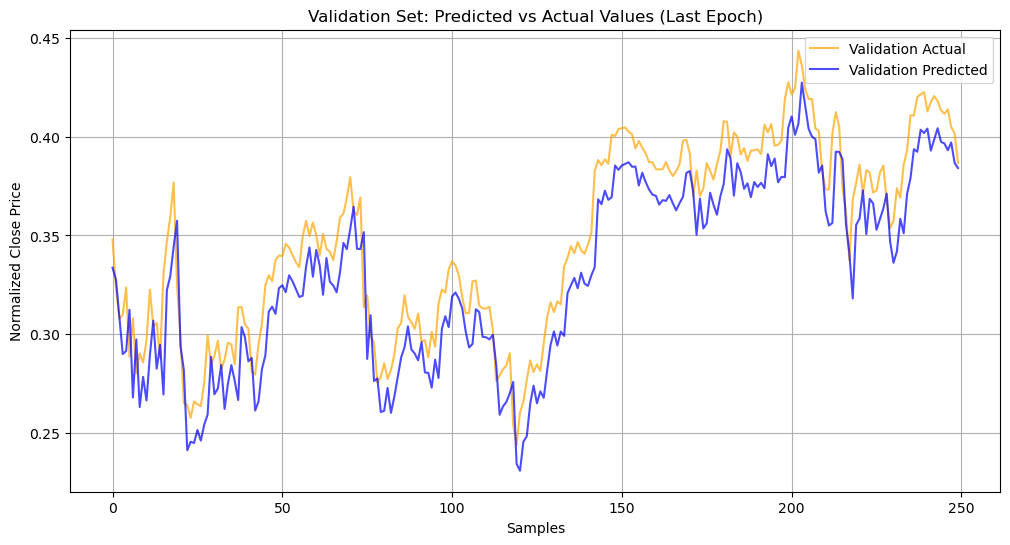

In [ ]:
best_params = optimizer.max['params']
hidden_dim = int(best_params['hidden_dim'])
learning_rate = float(best_params['learning_rate'])
num_layers = int(best_params['num_layers'])

model = VanillaRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience_counter = 0
patience = 10
num_epochs = 100 

train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_actuals, val_actuals = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    epoch_val_pred, epoch_val_actual = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            epoch_val_pred.extend(y_pred.cpu().numpy())
            epoch_val_actual.extend(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_predictions.append(epoch_val_pred)
    val_actuals.append(epoch_val_actual)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

val_pred_last = np.array(val_predictions[-1])
val_actual_last = np.array(val_actuals[-1])

plt.figure(figsize=(12, 6))
plt.plot(val_actual_last, label='Validation Actual', color='orange', alpha=0.7)
plt.plot(val_pred_last, label='Validation Predicted', color='blue', alpha=0.7)
plt.title('Validation Set: Predicted vs Actual Values (Last Epoch)')
plt.xlabel('Samples')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid()
plt.show()


#### Testing 

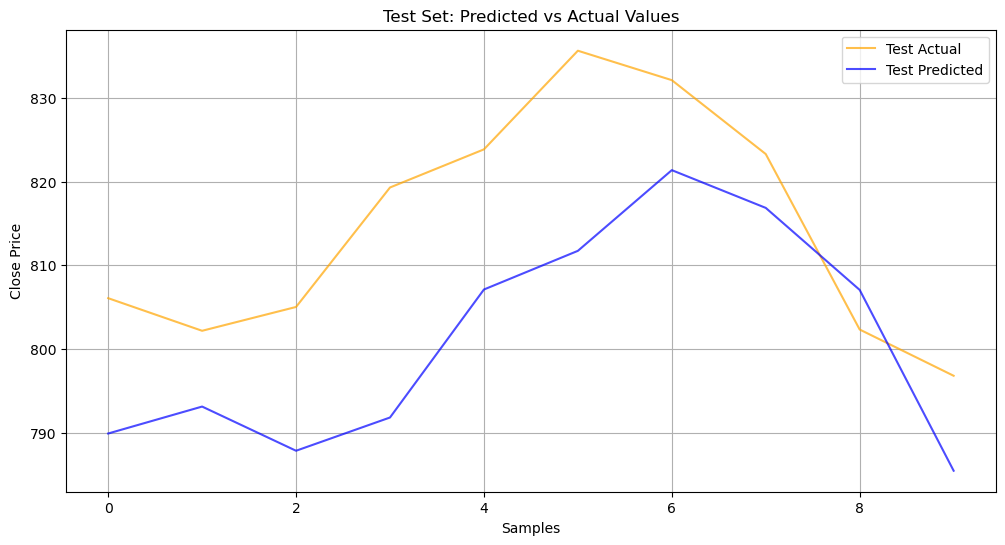

Test RMSE: 16.00
Test MAE: 14.40
Test MAPE: 1.76%


In [ ]:
model.eval()
test_predictions, test_actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        test_predictions.extend(y_pred.cpu().numpy())
        test_actuals.extend(y_batch.cpu().numpy())

test_predictions = np.array(test_predictions).flatten()
test_actuals = np.array(test_actuals).flatten()

close_min = scaler.data_min_[numerical_data.columns.get_loc('Close')]
close_max = scaler.data_max_[numerical_data.columns.get_loc('Close')]

test_predictions_rescaled = test_predictions * (close_max - close_min) + close_min
test_actuals_rescaled = test_actuals * (close_max - close_min) + close_min

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_rescaled, label='Test Actual', color='orange', alpha=0.7)
plt.plot(test_predictions_rescaled, label='Test Predicted', color='blue', alpha=0.7)
plt.title('Test Set: Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse = np.sqrt(mean_squared_error(test_actuals_rescaled, test_predictions_rescaled))
test_mae = mean_absolute_error(test_actuals_rescaled, test_predictions_rescaled)
test_mape = np.mean(np.abs((test_actuals_rescaled - test_predictions_rescaled) / test_actuals_rescaled)) * 100
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

### Feature engineering

In [ ]:

set_seed(42)
def add_features(df):
    df['MA5'] = df['Close'].rolling(window=5).mean().bfill()
    df['MA10'] = df['Close'].rolling(window=10).mean().bfill()
    df['Change'] = df['Close'].pct_change().fillna(0) 
    df['Volatility'] = df['Close'].rolling(window=5).std().bfill()
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low']  
    return df

train_data = add_features(train_data)
test_data = add_features(test_data)

numerical_data1 = train_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'Change', 'Volatility', 'High_Low_Pct']]
test_features1 = test_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'Change', 'Volatility', 'High_Low_Pct']]

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(numerical_data1)
normalized_df_feature = pd.DataFrame(normalized_data, columns=numerical_data1.columns)
normalized_test_data = scaler.transform(test_features1)
normalized_test_df_feature = pd.DataFrame(normalized_test_data, columns=test_features1.columns)

N = 10 
M = 1  
X, y = create_lstm_data(normalized_df_feature, target_column='Close', N=N, M=M)
X_test, y_test = create_lstm_data(normalized_test_df_feature, target_column='Close', N=N, M=M)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_size = int(0.8 * len(X_tensor))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

### RFE for feature selection

In [ ]:
rf = RandomForestRegressor(random_state=42)

selector = RFE(estimator=rf, n_features_to_select=2)
X_selected = selector.fit_transform(numerical_data1, train_data['Close'])

selected_features = numerical_data1.columns[selector.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['MA5', 'MA10']


Epoch 1/100, Train Loss: 0.0244, Val Loss: 0.0025
Epoch 2/100, Train Loss: 0.0029, Val Loss: 0.0006
Epoch 3/100, Train Loss: 0.0022, Val Loss: 0.0004
Epoch 4/100, Train Loss: 0.0021, Val Loss: 0.0004
Epoch 5/100, Train Loss: 0.0019, Val Loss: 0.0004
Epoch 6/100, Train Loss: 0.0019, Val Loss: 0.0003
Epoch 7/100, Train Loss: 0.0018, Val Loss: 0.0003
Epoch 8/100, Train Loss: 0.0016, Val Loss: 0.0004
Epoch 9/100, Train Loss: 0.0016, Val Loss: 0.0003
Epoch 10/100, Train Loss: 0.0015, Val Loss: 0.0003
Epoch 11/100, Train Loss: 0.0015, Val Loss: 0.0003
Epoch 12/100, Train Loss: 0.0016, Val Loss: 0.0003
Epoch 13/100, Train Loss: 0.0015, Val Loss: 0.0003
Epoch 14/100, Train Loss: 0.0014, Val Loss: 0.0005
Epoch 15/100, Train Loss: 0.0014, Val Loss: 0.0003
Epoch 16/100, Train Loss: 0.0014, Val Loss: 0.0004
Epoch 17/100, Train Loss: 0.0013, Val Loss: 0.0003
Early stopping triggered.


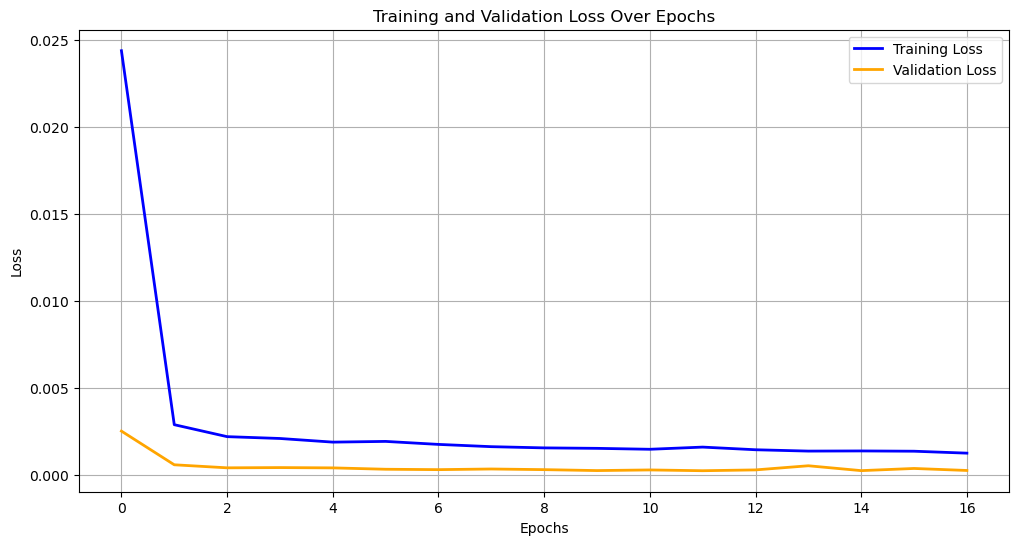

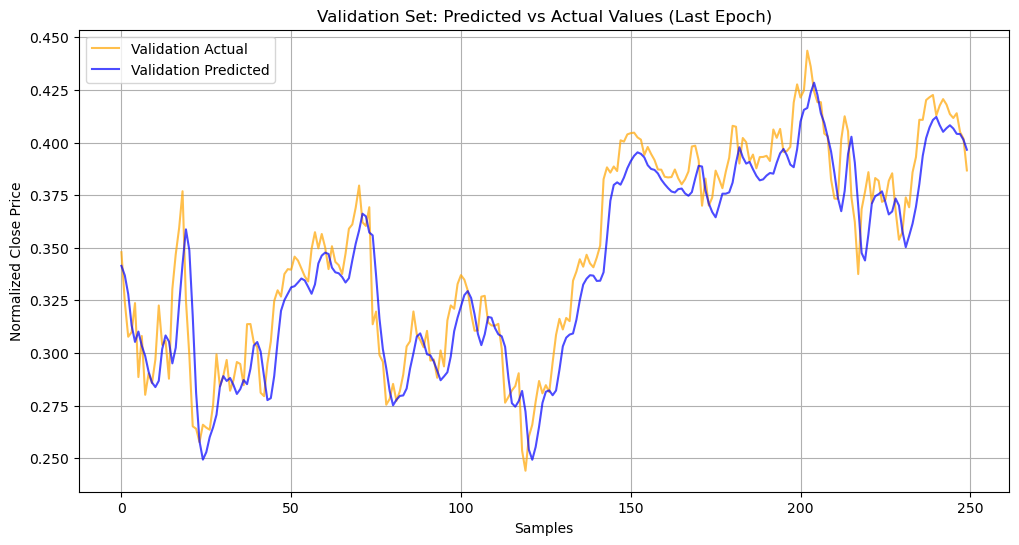

In [ ]:

set_seed(42)
numerical_data = train_data[[ 'Close','MA5', 'MA10']]  
test_features = test_data[['Close','MA5', 'MA10']]

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(numerical_data)
normalized_df_feature = pd.DataFrame(normalized_data, columns=numerical_data.columns)
normalized_test_data = scaler.transform(test_features)
normalized_test_df_feature = pd.DataFrame(normalized_test_data, columns=test_features.columns)

X, y = create_lstm_data(normalized_df_feature, target_column='Close', N=N, M=M)
X_test, y_test = create_lstm_data(normalized_test_df_feature, target_column='Close', N=N, M=M)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_size = int(0.8 * len(X_tensor))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]
input_dim = X.shape[2] 
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

model = VanillaRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
val_predictions, val_actuals = [], [] 
patience_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    epoch_val_pred, epoch_val_actual = [], [] 
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            epoch_val_pred.extend(y_pred.cpu().numpy())
            epoch_val_actual.extend(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_predictions.append(epoch_val_pred)
    val_actuals.append(epoch_val_actual)  

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2, color='blue')
plt.plot(val_losses, label='Validation Loss', linewidth=2, color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

val_pred_last = np.array(val_predictions[-1])
val_actual_last = np.array(val_actuals[-1])
plt.figure(figsize=(12, 6))
plt.plot(val_actual_last, label='Validation Actual', color='orange', alpha=0.7)
plt.plot(val_pred_last, label='Validation Predicted', color='blue', alpha=0.7)
plt.title('Validation Set: Predicted vs Actual Values (Last Epoch)')
plt.xlabel('Samples')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid()
plt.show()

#### testing

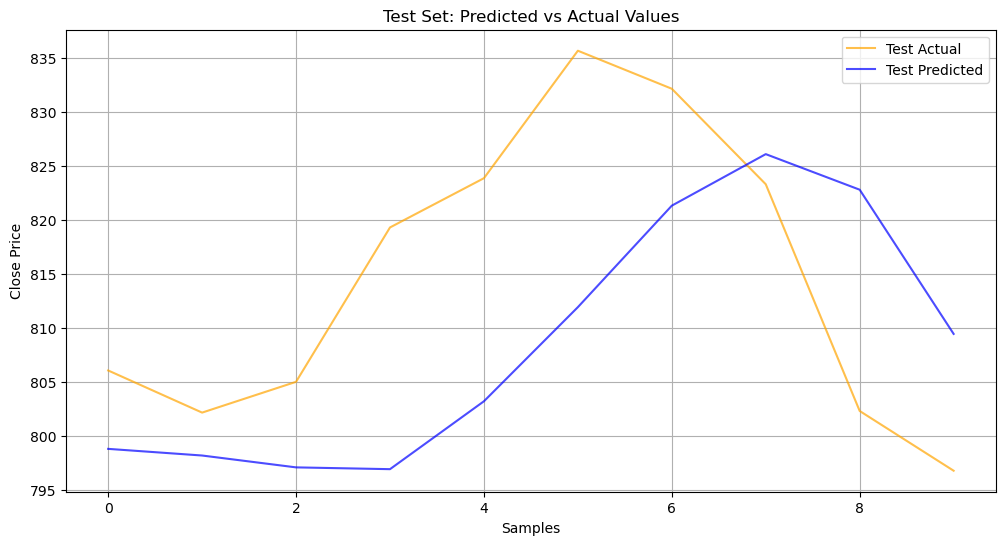

Test RMSE: 15.25
Test MAE: 13.27
Test MAPE: 1.62%


In [ ]:

set_seed(42)
model.eval()
y_test_pred, y_test_actual = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_test_pred.extend(y_pred.cpu().numpy())
        y_test_actual.extend(y_batch.cpu().numpy())

close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
y_test_pred_rescaled = np.array(y_test_pred).flatten() * (close_max - close_min) + close_min
y_test_actual_rescaled = np.array(y_test_actual).flatten() * (close_max - close_min) + close_min

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_rescaled, label='Test Actual', color='orange', alpha=0.7)
plt.plot(y_test_pred_rescaled, label='Test Predicted', color='blue', alpha=0.7)
plt.title('Test Set: Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
test_mape = np.mean(np.abs((y_test_actual_rescaled - y_test_pred_rescaled) / y_test_actual_rescaled)) * 100

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

### TUning

In [ ]:
def lstm_objective(hidden_dim, learning_rate, num_layers, look_back_window):
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    look_back_window = int(look_back_window)
    learning_rate = float(learning_rate)
    
    X, y = create_lstm_data(normalized_df_feature, target_column='Close', N=look_back_window, M=M)
    X_test, y_test = create_lstm_data(normalized_test_df_feature, target_column='Close', N=look_back_window, M=M)
    
    input_dim = X.shape[2]
    
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    train_size = int(0.8 * len(X_tensor))
    X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
    
    model = VanillaRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    num_epochs = 50 
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return -best_val_loss 
pbounds = {
    'hidden_dim': (50, 100), 
    'learning_rate': (1e-4, 1e-2),  
    'num_layers': (2, 4),          
    'look_back_window': (10, 19)   
}
optimizer = BayesianOptimization(
    f=lstm_objective,
    pbounds=pbounds,
    random_state=42, 
    verbose=2         
)

optimizer.maximize(
    init_points=5, 
    n_iter=50     
)
best_params = optimizer.max['params']
hidden_dim = int(best_params['hidden_dim'])
learning_rate = float(best_params['learning_rate'])
num_layers = int(best_params['num_layers'])
look_back_window = int(best_params['look_back_window'])
print(f"Best Parameters: {best_params}")

|   iter    |  target   | hidden... | learni... | look_b... | num_la... |
-------------------------------------------------------------------------
| 1         | -0.000271 | 68.73     | 0.009512  | 16.59     | 3.197     |
| 2         | -0.000158 | 57.8      | 0.001644  | 10.52     | 3.732     |
| 3         | -0.000214 | 80.06     | 0.00711   | 10.19     | 3.94      |
| 4         | -0.000164 | 91.62     | 0.002202  | 11.64     | 2.367     |
| 5         | -0.000163 | 65.21     | 0.005295  | 13.89     | 2.582     |
| 6         | -0.000165 | 91.53     | 0.004925  | 11.57     | 2.155     |
| 7         | -0.000249 | 61.97     | 0.004294  | 11.9      | 2.834     |
| 8         | -0.000167 | 55.64     | 0.007543  | 10.5      | 3.212     |
| 9         | -0.000228 | 56.52     | 0.002486  | 13.13     | 3.485     |
| 10        | -0.000164 | 58.02     | 0.008601  | 10.07     | 2.151     |
| 11        | -0.000159 | 90.16     | 0.00621   | 13.96     | 2.176     |
| 12        | -0.000188 | 88.56     | 

#### Retraining with best parameters and testing

In [ ]:
numerical_data = train_data[[ 'Close']]
test_features = test_data[['Close']]  

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(numerical_data)
normalized_df_feature = pd.DataFrame(normalized_data, columns=numerical_data.columns)
normalized_test_data = scaler.transform(test_features)
normalized_test_df_feature = pd.DataFrame(normalized_test_data, columns=test_features.columns)

X, y = create_lstm_data(normalized_df_feature, target_column='Close', N=N, M=M)
X_test, y_test = create_lstm_data(normalized_test_df_feature, target_column='Close', N=N, M=M)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_size = int(0.8 * len(X_tensor))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]
input_dim = X.shape[2]  
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Training with Best Parameters: Hidden Dim: 84, Learning Rate: 0.005363328371824638, Num Layers: 2, Look Back Window: 18
Epoch 1/50, Train Loss: 0.0385, Val Loss: 0.0004
Validation loss improved to 0.0004, saving model.
Epoch 2/50, Train Loss: 0.0014, Val Loss: 0.0003
Validation loss improved to 0.0003, saving model.
Epoch 3/50, Train Loss: 0.0011, Val Loss: 0.0005
No improvement in validation loss for 1 epoch(s).
Epoch 4/50, Train Loss: 0.0018, Val Loss: 0.0002
Validation loss improved to 0.0002, saving model.
Epoch 5/50, Train Loss: 0.0019, Val Loss: 0.0014
No improvement in validation loss for 1 epoch(s).
Epoch 6/50, Train Loss: 0.0015, Val Loss: 0.0004
No improvement in validation loss for 2 epoch(s).
Epoch 7/50, Train Loss: 0.0014, Val Loss: 0.0004
No improvement in validation loss for 3 epoch(s).
Epoch 8/50, Train Loss: 0.0013, Val Loss: 0.0003
No improvement in validation loss for 4 epoch(s).
Epoch 9/50, Train Loss: 0.0012, Val Loss: 0.0002
Validation loss improved to 0.0002, sav

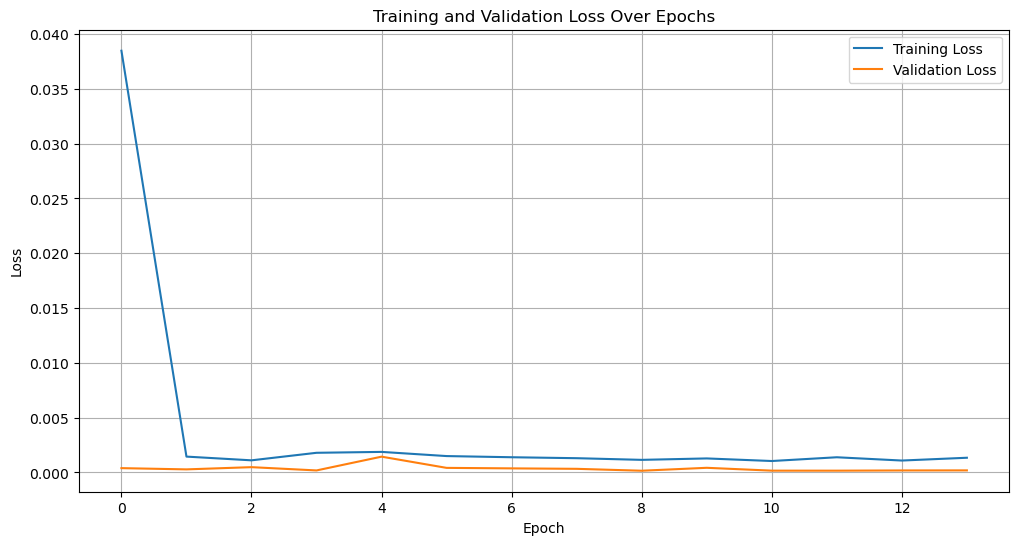

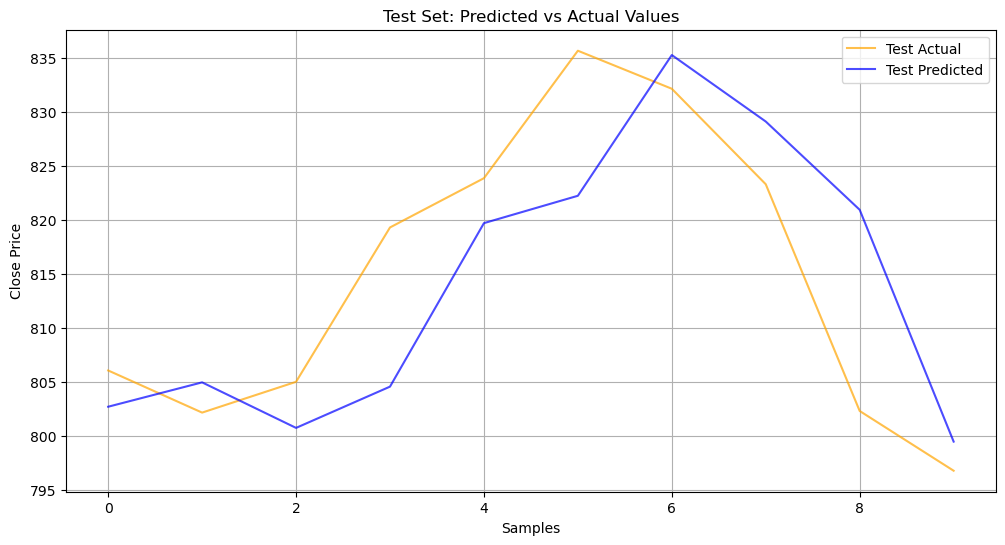

Test RMSE: 9.22
Test MAE: 7.30
Test MAPE: 0.89%


In [ ]:
set_seed(42)
hidden_dim = int(best_params['hidden_dim'])
learning_rate = float(best_params['learning_rate'])
num_layers = int(best_params['num_layers'])
look_back_window = int(best_params['look_back_window'])

print(f"Training with Best Parameters: Hidden Dim: {hidden_dim}, Learning Rate: {learning_rate}, Num Layers: {num_layers}, Look Back Window: {look_back_window}")

input_dim = 1
output_dim = M
model = VanillaRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50  
train_losses, val_losses = [], []

patience = 5 
best_val_loss = float('inf') 
patience_counter = 0 

for epoch in range(num_epochs):
  
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
        print(f"Validation loss improved to {best_val_loss:.4f}, saving model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model 
model.eval()
y_test_pred, y_test_actual = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_test_pred.extend(y_pred.cpu().numpy())
        y_test_actual.extend(y_batch.cpu().numpy())

close_min = scaler.data_min_[0] 
close_max = scaler.data_max_[0]
y_test_pred_rescaled = np.array(y_test_pred).flatten() * (close_max - close_min) + close_min
y_test_actual_rescaled = np.array(y_test_actual).flatten() * (close_max - close_min) + close_min

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_rescaled, label='Test Actual', color='orange', alpha=0.7)
plt.plot(y_test_pred_rescaled, label='Test Predicted', color='blue', alpha=0.7)
plt.title('Test Set: Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Calculate performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
test_mape = np.mean(np.abs((y_test_actual_rescaled - y_test_pred_rescaled) / y_test_actual_rescaled)) * 100
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")